## This experiment was conducted to test if the Generator is running correctly or not so as ensure that the SRGAN model was using the correct model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
import logging as log
from torchvision import transforms, datasets
BATCH_SIZE = 200
DATASET = 3000

In [2]:
class Points(torch.utils.data.Dataset):
    def __init__(self,ids):
        self.ids = ids
    def __len__(self):
        return len(self.ids)
    def __getitem__(self,index):
        Id = self.ids[index]
        X = torch.load('data/' + str(Id)+'.pt')        
        return X

In [3]:
ids = np.arange(1,DATASET + 1,1)
training = Points(ids)

In [4]:
training_gen = torch.utils.data.DataLoader(training, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
num_batches = len(training_gen)

# NETWORKS

In [5]:
class Encoder(torch.nn.Module):
    '''
    Double hidden layer generator network
    '''
    def __init__(self):
        super(Encoder,self).__init__()
        n_features = 2
        n_hidden1 = 10
        n_hidden2 = 10
        n_out = 3
        
        self.hidden1 = nn.Sequential(nn.Linear(n_features,n_hidden1),nn.LeakyReLU(0.2))
        self.hidden2 = nn.Sequential(nn.Linear(n_hidden1,n_hidden2),nn.LeakyReLU(0.2))
        self.out = nn.Sequential(nn.Linear(n_hidden2,n_out),nn.Sigmoid())
        
    def forward(self,x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [47]:
encoder = Encoder()
if torch.cuda.is_available():
    encoder.cuda()

In [48]:
enc_opt = optim.Adam(encoder.parameters(), lr = 0.01)

In [49]:
encoder

Encoder(
  (hidden1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (out): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Sigmoid()
  )
)

In [50]:
criterion = torch.nn.MSELoss()

In [51]:
error_arr = []

In [52]:
EPOCHS = 50

In [53]:
for epoch in range(EPOCHS):
    err_avg = 0
    for batch_num, real_batch in enumerate(training_gen):
        enc_opt.zero_grad()
        real_data = real_batch.cuda()
        pred_data = encoder(real_data[:,0:2])
        error = criterion(real_data, pred_data)
        error.backward()
        enc_opt.step()
        err_avg+=error
    
    err_avg/=num_batches
    error_arr.append(err_avg)
    if epoch%10==0:
        print("Epoch: {} , Error: {}".format(epoch,err_avg))

Epoch: 0 , Error: 0.10734640061855316
Epoch: 10 , Error: 0.0009359958930872381
Epoch: 20 , Error: 0.0007757400744594634
Epoch: 30 , Error: 0.0006677504861727357
Epoch: 40 , Error: 0.00028923919307999313


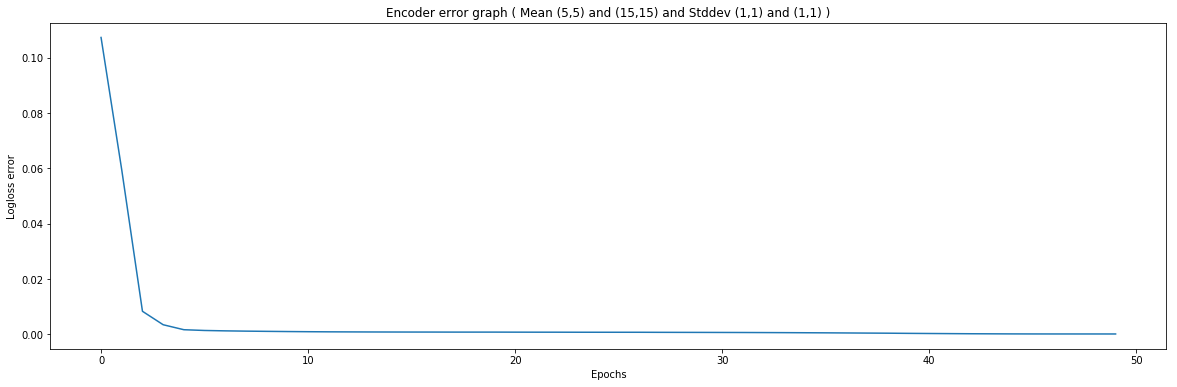

In [54]:
#graph comparison
fig,ax = plt.subplots(figsize = (20,6))
ax.plot(error_arr)
ax.set_xlabel('Epochs')
ax.set_ylabel('Logloss error')
ax.set_title("Encoder error graph ( Mean (5,5) and (15,15) and Stddev (1,1) and (1,1) )")
plt.show()

In [55]:
def comparedata(pp):
    pp = [list(np.array(x)) for x in pp]  
    pp = torch.tensor(pp)
    
#     print(pp.device)
    fig, ax = plt.subplots(1,3,figsize = (20,5))
    ax[0].scatter(pp[:,0],pp[:,1])
    ax[1].scatter(pp[:,1],pp[:,2])
    ax[2].scatter(pp[:,0],pp[:,2])
    
#     #gen data
    b = encoder(pp[:,0:2].cuda()).cpu().detach()
#     print(b.device)
    fig2, ax2 = plt.subplots(1,3,figsize = (20,5))
    ax2[0].scatter(b[:,0],b[:,1],color = 'red')
    ax2[1].scatter(b[:,1],b[:,2],color = 'red')
    ax2[2].scatter(b[:,0],b[:,2],color = 'red')
#     plt.title('Trimodal data with mean (1,1), (6,6) and (11,11) and stddev (0.5,0.5), (0.6,0.6),(1,1)')
    plt.show()

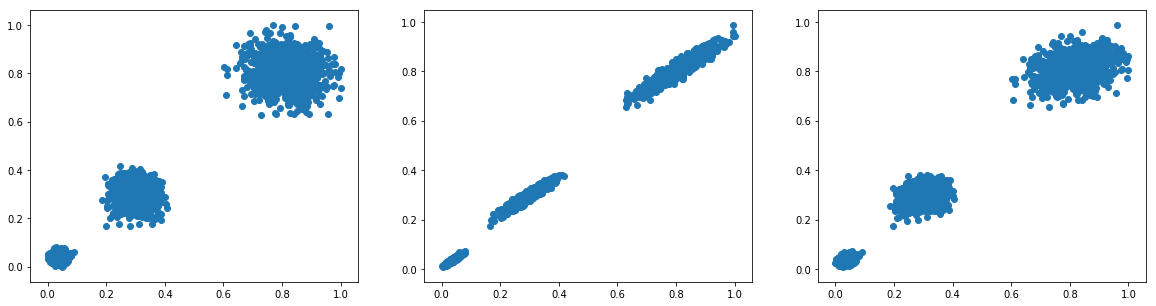

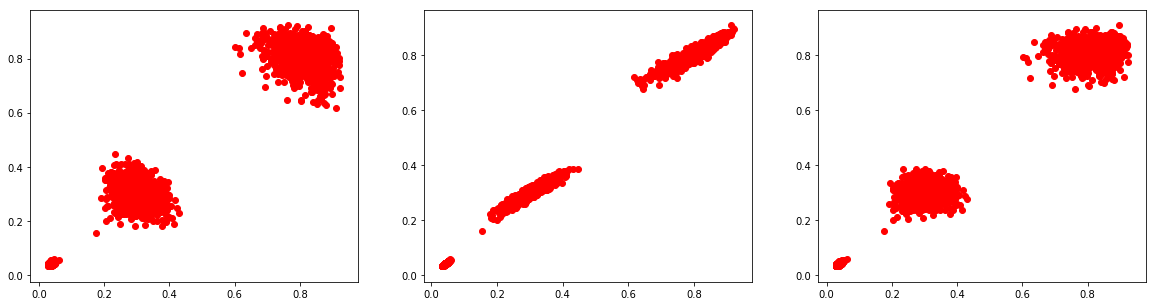

In [56]:
pp = []
for i in range(DATASET):
    pp.append(torch.load('data/'+ str(i+1) + '.pt'))
comparedata(pp)